# Physical-Mathematical Model : BP = f(VCG)

# Connect to GCS

In [47]:
import os
from utils.constants import *
%cd {os.environ['PROJECT_PATH']}
# os.environ['PYTHONPATH'] = os.environ['PYTHONPATH'] + '/src/'

/app


In [25]:
# import os
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'creds/nipams-83df6260e5a8.json'
# !echo $GOOGLE_APPLICATION_CREDENTIALS

# Instantiates a client
from google.cloud import storage
client = storage.Client()

# import re
# re.match('asdf', 'data_cleaned_LVET_m/sub019_LLV1.mat')

bucket = client.get_bucket('data_cleaned_lvet')

# # https://stackoverflow.com/questions/22398898/google-cloud-storage-python-any-way-to-list-obj-in-certain-folder-in-gcs
blobs = list(bucket.list_blobs(10, prefix='data_cleaned_LVET_m/'))

In [60]:
def getBpDataFromMatlab(dictImuData):
  bp_all = np.asarray(dictImuData['mlts_now'])
  dfBp = pd.DataFrame(bp_all, columns=BP_COLS)
  dfBp.index.name = 'heartbeat'
  return dfBp

def getImuDataFromMatlab(dictImuData):
  imu_all = np.asarray(dictImuData['mlfs_now'])
  imuShape = imu_all.shape
  imuInd = pd.MultiIndex.from_product([range(imuShape[2]), range(imuShape[0])], names=['heartbeat','step_index'])
  dfRaw = pd.concat([pd.DataFrame(imu_all[:,:,i]) for i in range(imuShape[2])]).reset_index(drop=True)
  dfRaw.columns = IMU_COLS
  dfRaw = dfRaw.set_index(imuInd).reset_index().drop('step_index', axis=1).set_index(['heartbeat','ts'])
  return dfRaw

def getContinuousDataFromMatlab(dictImuData):
  dfBpRaw = pd.concat([
    pd.DataFrame(dictImuData['bio_data'][:,[17,14,15]], columns=BP_COLS),
    pd.DataFrame(dictImuData['bio_ts']).T.rename(columns={0:'ts'}),
    pd.DataFrame(dictImuData['bio_data'][:,12], columns=['ecgTs'])
  ], axis=1)
  dfBpRaw.ts = pd.to_timedelta(dfBpRaw.ts, unit='s')

  dfImuRaw = pd.concat([
    pd.DataFrame(dictImuData['imu_data'], columns=IMU_DATA_COLS),
    pd.DataFrame(dictImuData['imu_ts']).rename(columns={0:'ts'})
  ], axis=1)
  dfImuRaw.ts = pd.to_timedelta(dfImuRaw.ts, unit='s')

  return dfImuRaw.set_index('ts'), dfBpRaw.set_index('ts')


In [69]:
folder=''
pattern='.*\.mat$'
continuous=True

matchedBlobs = [blob for blob in blobs if re.match(pattern, blob.name)][:10]

blobFileNames = {}
arrDfsImu, arrDfsBp = [], []
for blob in matchedBlobs:
    blob.download_to_filename('data/raw_mat/'+blob.name.split('/')[-1])
    imuFile = loadmat('data/raw_mat/'+blob.name.split('/')[-1])

    if True:
        dfImu, dfBp = getContinuousDataFromMatlab(imuFile)
    else:
        dfBp = getBpDataFromMatlab(imuFile)
        dfImu = getImuDataFromMatlab(imuFile)
    dfBp['file'] = blob.name
    dfImu['file'] = blob.name
    arrDfsBp.append(dfBp)
    arrDfsImu.append(dfImu)

/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.

In [61]:
blob = blobs[2]
blob.download_to_filename('data/raw_mat/'+blob.name.split('/')[-1])
imuFile = loadmat('data/raw_mat/'+blob.name.split('/')[-1])
  
dfImu, dfBp = getContinuousDataFromMatlab(imuFile)
# dfBp = getBpDataFromMatlab(imuFile)
# dfImu = getImuDataFromMatlab(imuFile)
dfBp['file'] = blob.name
dfImu['file'] = blob.name
arrDfsBp.append(dfBp)
arrDfsImu.append(dfImu)

NameError: name 'arrDfsBp' is not defined

In [65]:
dfBp.pp.value_counts(dropna=False)

NaN           3892
90.563651     1003
72.975275      875
96.557691      853
69.000235      853
              ... 
85.096944      461
100.008360     453
103.608461     443
100.522361     439
99.687307      437
Name: pp, Length: 440, dtype: int64

In [124]:
from data import load_data
from importlib import reload
reload(load_data)

/app/src/data/load_data.py:8: DeprecationWarning: invalid escape sequence \.
  MAT_FILE_PATTERN = '.*\.mat$'
/app/src/data/load_data.py:117: DeprecationWarning: invalid escape sequence \d
  #### EXECUTION ####


<module 'data.load_data' from '/app/src/data/load_data.py'>

In [80]:
load_data.connect_gcs()
dfImuAll, dfBpAll = load_data.load_data_gcs()


/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.

In [127]:
dfImuAll, dfBpAll = load_data.load_dataframe_from_mat('data/raw_mat/')
dfImuCont, dfBpCont = dfImuAll, dfBpAll


sub019_rec2.mat    169053
sub019_rec1.mat    168818
sub115_bre1.mat    149533
sub112_res1.mat    102930
sub133_LLV1.mat     32752
sub115_LLV3.mat     28807
sub112_HLV1.mat     24180
sub115_LLV1.mat     24147
sub112_HLV2.mat     17495
sub019_LLV1.mat     16097
Name: file, dtype: int64

# 1) Load & Prep Nipams Data

In [2]:
import os
from utils.constants import *
%cd {os.environ['PROJECT_PATH']}

/app


In [3]:
from data import load_data
from importlib import reload
reload(load_data)

<module 'data.load_data' from '/app/src/data/load_data.py'>

In [4]:
dfImuAll, dfBpAll = load_data.load_dataframe_from_mat('data/raw_mat/')
dfImuCont, dfBpCont = dfImuAll, dfBpAll
dfImuCont.file.value_counts()

/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.

sub019_rec2.mat    169053
sub019_rec1.mat    168818
sub115_bre1.mat    149533
sub112_res1.mat    102930
sub133_LLV1.mat     32752
sub115_LLV3.mat     28807
sub112_HLV1.mat     24180
sub115_LLV1.mat     24147
sub112_HLV2.mat     17495
sub019_LLV1.mat     16097
Name: file, dtype: int64

# 2) Preprocess

In [5]:
import nipams_ml as nm
# reload(nm.preprocess)

## 2.1) Prepocess - James

In [6]:
dfBp, dfImuRaw = nm.preprocess.filterSplit(dfBpCont.set_index('ts'),dfImuCont.set_index('ts'))
dfImuRaw['ts'] = dfImuRaw.index.total_seconds()
dfImuRaw = dfImuRaw.reset_index(drop=True)
dfImuRaw = dfImuRaw.set_index('file')

dfAll = dfImuRaw.merge(dfBp, how='left', on=nm.constants.INDICIES)
dfAll.ts = pd.to_timedelta(dfAll.ts*1e9)

/app/src/nipams_ml/preprocess.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfBpAll = dfBpAll.append(BpTargets)
/app/src/nipams_ml/preprocess.py:102: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfImuRawAll = dfImuRawAll.append(dfImuSamp)
/app/src/nipams_ml/preprocess.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfBpAll = dfBpAll.append(BpTargets)
/app/src/nipams_ml/preprocess.py:102: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfImuRawAll = dfImuRawAll.append(dfImuSamp)
/app/src/nipams_ml/preprocess.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

# 3) Define the Model

In [7]:
#@title Helper Methods

########################## DATA HELPERS ##########################
## Return the IMU & BP data for a specific heartbeat
def get_vcg_data_for_hb(selectedFile, selectedHb, dfAll=dfAll):
  # Get data for individual heartbeat
  selected_data = dfAll[(dfAll.file.str.contains(selectedFile)) &\
                                  (dfAll['heartbeat'] == selectedHb)]
  selected_data = selected_data.set_index('ts')
  # selected_data = selected_data.fillna(method='ffill').fillna(method='bfill')
  return selected_data


########################## MATH HELPERS ##########################
## Return the Double Integral of Signal (aka Vector)
from scipy import integrate
def displacement(vcg_sig):
  vcg_sig = vcg_sig - vcg_sig.mean()   # TODO : Remove 'accelerometer drift'?

  # Double Integral
  serX=vcg_sig.index.astype(int)/1e9
  vz = integrate.cumtrapz(y=vcg_sig,x=serX)-vcg_sig.mean()   ## TODO : is this the best approach?
  # serVzX=vz.index.astype(int)/1e9
  dz = integrate.cumtrapz(y=vz-vz.mean(), x=serX[1:])
  return dz, vz


## Calculate RMS Envelope -- TODO : use timestamp for pd.rolling instead of np.convolve
def window_rms(a, window_size):
  a2 = np.power(a,2)
  window = np.ones(window_size)/float(window_size)
  return np.sqrt(np.convolve(a2, window, 'valid'))


########################## Plugin HELPERS ##########################
## Plugin function to allow 'ingecting' code snippets during execution
def plugin(name, pluginFns, localDict):
  fns = pluginFns.get(name, [])
  fns = [fns] if isinstance(fns, str) else fns
  [exec(fn['fn'], globals(), {**localDict, **fn['context']}) if isinstance(fn, dict)
      else exec(fn, globals(), localDict) 
      for fn in fns]
## Take snapshots of important data while executing..
def DataLog():
  db = {}
  def save(name, data):
    if name not in db : db[name] = []
    db[name].append(data)
  return db, save

![](https://drive.google.com/uc?export=view&id=1ui2A_fUNQqOJ3uxgx_yfMOpv_cMXDvj5)

Image Source : https://drive.google.com/file/d/1ui2A_fUNQqOJ3uxgx_yfMOpv_cMXDvj5/view?usp=sharing


In [8]:
#@title 🧠 Implement Physical-Mathematical Model

## Input : Data-VCG for single heartbeat. Output : Calculated BP
def calculate_BP_from_VCG(df_vcg, params={'k1':1.,'k2':1.}, pluginFns={}):
  plugin('start',pluginFns, locals())
  
  ##### Get Vectors (signals) from df_vcg #####
  vcg_xp = df_vcg['az']
  # vcg_aar = df_vcg['ax']    # TODO : Fetch VCG_Aar, using ax for now..
  plugin('vcg',pluginFns, locals())

  ##### Acceleration -> Displacement #####
  dXp, vXp = displacement(vcg_xp)
  # dXp_y, vXp_y = displacement(df_vcg['ay'])
  dXp_z, vXp_z = displacement(df_vcg['az'])
  # dXp_Norm = np.linalg.norm(np.array([dXp,dXp_y,dXp_z]), axis=0)
  dXp_Norm = np.linalg.norm(np.array([dXp,dXp_z]), axis=0)
  
  # dAar, vAar = displacement(vcg_aar)
  # deltaDisp = dXp - dAar
  deltaDisp = dXp_Norm
  plugin('disp',pluginFns, locals())

  ##### Respiration Volume #####
  RV = window_rms(vcg_xp, 20).max()
  plugin('RV',pluginFns, locals())

  ##### BP at Aorta #####
  bp_Aar = params['k1'] * deltaDisp / RV    ## TODO : is trimming this to size okay?

  ##### Beat to Beat #####
  BTB = (vcg_xp.index.max() - vcg_xp.index.min()).total_seconds()

  BP_f = BTB * bp_Aar + params['k2']
  
  ##### Finalize SBP and DBP #####
  SBP = BP_f.max()
  DBP = BP_f.min()
  plugin('BP',pluginFns, locals())
  
  ##### End #####
  plugin('end',pluginFns, locals())
  return SBP, DBP


In [9]:
#@title 🔎  Select Individual File-Heartbeat and Calculate

##### Choose Specific File & HeartBeat -OR- Random.. #####
# selectedHb, selectedFile = 3.0, 'sub200/sub200_HLV1.mat'
selectedFile, selectedHb = dfAll[['file','heartbeat']].sample(1).iloc[0].to_list()   ## Choose Random from DF

## Filter for VCG Data for Specific Heartbeat
dfHb = get_vcg_data_for_hb(selectedFile, selectedHb)

## Pass VCG Data and Calculate BP
SBP, DBP = calculate_BP_from_VCG(dfHb)
print(f'SBP: {SBP.round(2)} -- DBP: {DBP.round(2)}\n')

SBP: 1.0 -- DBP: 1.0



# 4) Run & Evaluate Model

In [10]:
#@title 🏃 Run Model For All Heartbeats
########################## SETUP TEST ##########################
NUM_HEARTBEATS = 30 #@param
if NUM_HEARTBEATS == -1:
  dfAll_ = dfAll.copy()
else : 
  randomHeartBeats = dfAll.groupby(['file','heartbeat']).count().sample(NUM_HEARTBEATS).index
  dfAll_ = dfAll.set_index(['file','heartbeat']).loc[randomHeartBeats].reset_index()

########################## LOGGERS (Optional) ##########################
## Define Logging functions (optional) to be injected in calculation steps
dataLogs, save = DataLog()
pluginFns={
    'disp':['save("az",vcg_xp.values)'],
    'RV':['save("vz",vXp)','save("dz",deltaDisp)'],
    'BP':['save("BTB",BTB)','save("bp_Aar",bp_Aar)']
}

########################## ITERATE HEARTBEATS ##########################
## Iterate File-Heartbeats - Calculate BP for each
results = {}
for inds, dfHb in dfAll_.groupby(['file','heartbeat']):
  ## Fetch VCG IMU data for individual heartbeat (aka 'inds')
  dfHb = get_vcg_data_for_hb(*inds)

  ## Choose Params for Patient
  params = {'k1':1e5,'k2':60.}

  ## Calculate BP from VCG
  SBP, DBP = calculate_BP_from_VCG(dfHb, params, pluginFns)
  
  ## Save Results
  result = {'sbp_pred':SBP,'dbp_pred':DBP,
                   'sbp':dfHb['sbp'].mean(),'dbp':dfHb['dbp'].mean()
  }
  results[inds] = result
  print(inds, dfHb.shape, ' ---> ', result)

dfResults = pd.DataFrame.from_dict(results).T

('sub019_LLV1.mat', 28.0) (226, 18)  --->  {'sbp_pred': 64.25629301470116, 'dbp_pred': 60.041886213663396, 'sbp': 135.7278490721571, 'dbp': 70.56574496604046}
('sub019_rec1.mat', 14.0) (108, 18)  --->  {'sbp_pred': 61.938361607219186, 'dbp_pred': 60.019725086200744, 'sbp': 149.96897672070168, 'dbp': 62.99835854856689}
('sub019_rec1.mat', 81.0) (126, 18)  --->  {'sbp_pred': 62.82260031676797, 'dbp_pred': 60.00215093925251, 'sbp': 151.06941327301274, 'dbp': 62.93800530476564}
('sub019_rec1.mat', 150.0) (152, 18)  --->  {'sbp_pred': 62.985021161633654, 'dbp_pred': 60.002517267780746, 'sbp': 138.55884239259686, 'dbp': 62.74424826483176}
('sub019_rec1.mat', 258.0) (160, 18)  --->  {'sbp_pred': 61.635036612764104, 'dbp_pred': 60.00323202331979, 'sbp': 146.75361782122442, 'dbp': 62.28376608072607}
('sub019_rec1.mat', 299.0) (162, 18)  --->  {'sbp_pred': 62.32043735991909, 'dbp_pred': 60.00356353855312, 'sbp': 134.00308358009923, 'dbp': 63.19588332047038}
('sub019_rec1.mat', 344.0) (164, 18)  

# 5) 🎉 Review Results & Evaluate

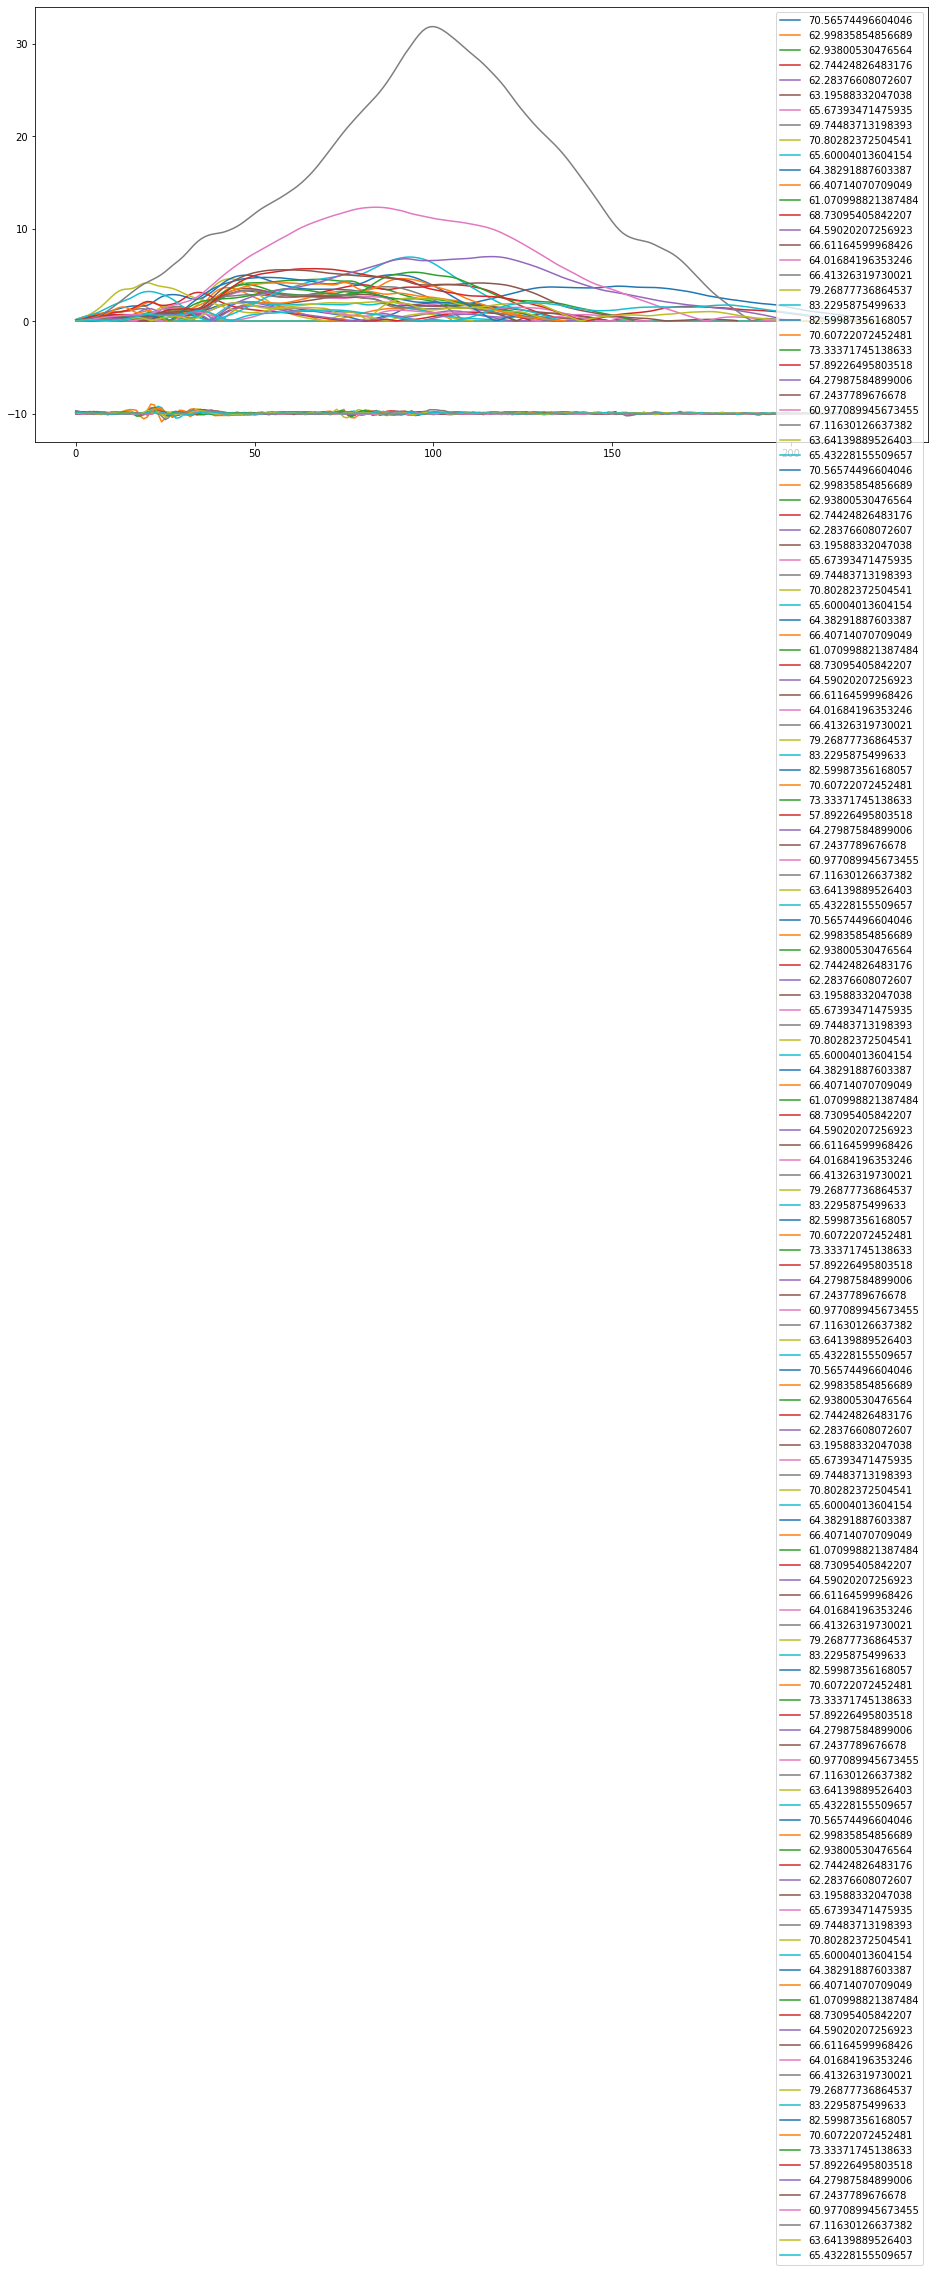

In [14]:
#@title Visualize VCG Signals (az, vz, dz)
# import ipywidgets as widgets

arrSigs = list(dataLogs.keys())
# arrSigs = list(dataLogs.keys())
# t = widgets.TabBar(arrSigs)
for i in arrSigs:
#   with t.output_to(i,select=False):
    [pd.Series(ser).plot(figsize=(16,8), label=dfResults.iloc[ind].dbp, legend=True) for ind,ser in enumerate(dataLogs[i])]

'Evaluation Metrics'

,0
RMSE,70.302580
MSE,4942.452782
mean_absolute_error,66.786937
STD of Absolute Error,22.328839
STD of Error,22.328839
r2_score,-13.319613


'Correlation : '

,sbp,sbp_pred
sbp,1.000000,-0.510251
sbp_pred,-0.510251,1.000000


'Evaluation Metrics'

,0
RMSE,9.232803
MSE,85.244654
mean_absolute_error,7.269118
STD of Absolute Error,5.789816
STD of Error,5.971193
r2_score,-1.467242


'Correlation : '

,dbp,dbp_pred
dbp,1.000000,0.262789
dbp_pred,0.262789,1.000000


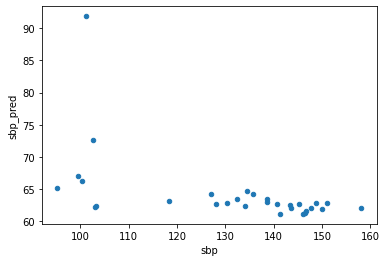

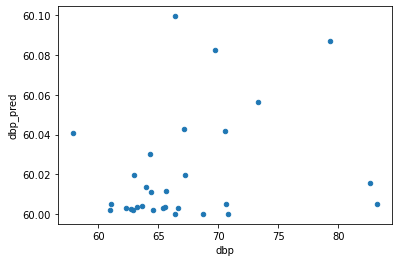

In [19]:
#@title Evaluate with MAE, R2 & Correlation Plots
import sklearn.metrics as skm

arrBps = ['sbp','dbp']
# t = widgets.TabBar(arrBps)
for i in arrBps:
  # with t.output_to(i,select=False):
    yTarget, yPreds = dfResults[i], dfResults[f'{i}_pred']

    objScores = {
      'RMSE': skm.mean_squared_error(yTarget, yPreds, squared=False),
      'MSE': skm.mean_squared_error(yTarget, yPreds, squared=True),
      'mean_absolute_error': skm.mean_absolute_error(yTarget, yPreds),
      'STD of Absolute Error': np.abs(yTarget - yPreds).std(),
      'STD of Error': (yTarget - yPreds).std(),
      'r2_score': skm.r2_score(yTarget, yPreds)
    }
    display('Evaluation Metrics', pd.DataFrame([objScores]).T)

    display('Correlation : ', dfResults[[i,f'{i}_pred']].corr())
    dfResults.plot.scatter(i,f'{i}_pred')

In [ ]:
STOP_HERE

##

# 6) Build Capatible Estimator

In [20]:
# https://stackoverflow.com/questions/31259891/put-customized-functions-in-sklearn-pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

In [21]:
class RandomRegressor():
  def fit(self, X, Y):
    self.serY = pd.Series(Y)
    return self
  def predict(self, rows, *args):
    return self.serY.sample(len(rows), replace=True).values
  def score(self, rows, y):
    return np.abs((self.predict(rows))-y)

def printer(x):
  print(x)
  return x

printerTrans = FunctionTransformer(printer)

In [22]:
dfImu = dfAll[nm.constants.INDICIES + nm.constants.IMU_COLS]
dfBp = dfAll[nm.constants.INDICIES + nm.constants.BP_COLS]
sampleRandTestInds = nm.experiments.split_by_random(dfImu, dfBp)
sampleExpDfs = nm.experiments.get_experiment(sampleRandTestInds[0], dfImu, dfBp)
# nm.experiments.split_by_random(dfAll[nm.constants.IMU_COLS])

In [23]:
RandomRegressor().fit(sampleExpDfs['test_x'],sampleExpDfs['test_y']['dbp']).predict(sampleExpDfs['test_y']['dbp'])

array([67.13110293, 73.26731139, 75.23312319, ..., 68.97674944,
       60.89238451, 63.22644034])

In [24]:
def forceShape(x, nrows=300):
  x = x[:nrows]
  return np.pad(x, ((0,nrows-x.shape[0]),(0,0)))

# arrData = np.array(list(dfAll.groupby(nm.constants.INDICIES).apply(lambda x : forceShape(x[['az','ax']].values))))

def explode_3d(input_series, indicies=nm.constants.INDICIES, data_cols=nm.constants.IMU_DATA_COLS):
  '''
    Converts timeseries signals dataframe into 3d matrix of ts samples
  '''
  # dfTsVect = input_series[indicies + data_cols].groupby(indicies, sort=False).fillna(0)
  arrTsExp = np.array(list(
      input_series\
        .groupby(nm.constants.INDICIES)\
        .apply(lambda x : forceShape(x[['ts','az','ax']].values).T)
      )
  )
  return arrTsExp


In [25]:
def vectorize_mean(input_series, indicies=nm.constants.INDICIES, data_cols=nm.constants.IMU_DATA_COLS):
  dfTsVect = input_series[indicies + data_cols].groupby(indicies, sort=False).agg(['mean','std']).fillna(0)
  dfTsVect.columns = ['_'.join(col).strip() for col in dfTsVect.columns.values]
  return dfTsVect

tsVectTransform = FunctionTransformer(vectorize_mean)

pipe = Pipeline([('scaler', tsVectTransform), ('rand', RandomRegressor())])
pipe.fit(sampleExpDfs['train_x'], sampleExpDfs['train_y'].groupby(nm.constants.INDICIES)['dbp'].mean())
pipe.score(sampleExpDfs['test_x'], sampleExpDfs['test_y'].groupby(nm.constants.INDICIES)['dbp'].mean())
preds = pipe.predict(sampleExpDfs['test_x'])
preds

array([65.54398985, 64.1986762 , 61.68632463, 67.73417259, 63.23232677,
       79.43477865, 62.29930062, 59.0987091 , 67.10541202, 63.45300147,
       65.57822819, 60.76235008, 76.5173597 , 38.48952129, 63.32536973,
       61.60674623, 65.08246188, 72.48673352, 67.11630127, 64.80749579,
       63.62203643, 63.05661855, 56.42462933, 68.8666828 , 67.07851531,
       65.89052485, 63.32536973, 65.6748342 , 44.97363309, 70.75154925,
       78.92211319, 64.76602499, 67.19905125, 67.59941321, 64.79171448,
       64.28194371, 73.91105459, 65.39100548, 74.27432073, 63.73557504,
       66.22042307, 42.63691767, 62.24574467, 73.75423676, 65.90864133,
       68.08650352, 79.43477865, 62.99835855, 71.40694158, 80.23411135,
       63.89539575, 58.66408868, 76.88260322, 63.87161535, 69.92576185,
       39.18036884, 66.17693611, 60.5825274 , 65.59007112, 75.82684953,
       58.5654517 , 65.83469235, 66.50461884, 65.95342941, 57.60059881,
       78.77947729, 68.60687349, 65.94007759, 68.60601578, 60.23

In [26]:
tsExplodeTransform = FunctionTransformer(explode_3d)

pipe = Pipeline([('scaler', tsExplodeTransform), ('rand', RandomRegressor())])
pipe.fit(sampleExpDfs['train_x'], sampleExpDfs['train_y'].groupby(nm.constants.INDICIES)['dbp'].mean())
pipe.score(sampleExpDfs['test_x'], sampleExpDfs['test_y'].groupby(nm.constants.INDICIES)['dbp'].mean())
preds = pipe.predict(sampleExpDfs['test_x'])
preds

array([61.95959272, 64.64990322, 62.99835855, 62.89521084, 66.49122175,
       61.62452157, 60.94479251, 64.29023673, 64.31478979, 67.67440184,
       65.22744483, 58.22314197, 77.87248585, 70.31309361, 66.08732256,
       60.39484521, 67.82201013, 64.62144054, 64.85784864, 64.59020207,
       73.42580683, 62.40142537, 66.80049674, 73.30468917, 74.27432073,
       42.63691767, 74.52676862, 78.94206634, 72.29312555, 65.59851689,
       58.48359775, 63.96930924, 61.98711003, 70.69142476, 63.82288609,
       62.3288382 , 59.31807041, 63.54990834, 59.51071735, 72.83870529,
       64.9925659 , 59.11360852, 64.96959511, 68.11567825, 60.13928652,
       60.34845414, 68.81565474, 64.42181406, 71.52080644, 66.26061048,
       63.87221506, 61.58369278, 65.79752061, 61.58369278, 63.98070182,
       63.87221506, 65.33580814, 67.64732538, 61.05805085, 64.91990815,
       74.98369887, 66.93373892, 68.13529449, 71.84835442, 80.04851928,
       62.89521084, 67.33714156, 39.36164499, 67.45295536, 62.90

In [27]:
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# https://scikit-learn.org/stable/developers/develop.html
class AnalyticalBPEstimator():
  def __init__(self, k1=700.,k2=100.):
    self.k1 = k1
    self.k2 = k2

  def fit(self, X, y):
    ## GridSearch Params
    
    # self.X_ = X
    # self.y_ = y
    # Return the classifier
    return self

  def predict(self, X):

    # closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
    y_preds = []
    for row in X:
      dfHeartBeat = pd.DataFrame(row.T, columns=['ts','az','ax']).replace(0, np.NaN).set_index('ts').dropna()
      y_pred = calculate_BP_from_VCG(dfHeartBeat[dfHeartBeat.index!=0], params={'k1':self.k1, 'k2':self.k2})
      y_preds.append(y_pred)
    return y_preds

In [28]:
X = tsExplodeTransform.fit_transform(sampleExpDfs['train_x'])

In [29]:
# X[0], sampleExpDfs['train_y'][0]
# sampleExpDfs['train_y']['sbp'].iloc[0]

In [ ]:
modAnalytical = AnalyticalBPEstimator().fit(X, sampleExpDfs['train_y'])
modAnalytical.predict(X)

In [31]:
#@title Grid Search Model Parameters

heartBeatNum = 0
arrK1 = [1e1,1e2,1e3,1e4,1e5]
arrK2 = [1e1,1e2,1e3,1e4,1e5]

print(sampleExpDfs['train_y']['sbp'].iloc[0])
for k1 in arrK1:
  for k2 in arrK2:
    modAnalytical.k1 = k1
    modAnalytical.k2 = k2
    preds = modAnalytical.predict(X[:1])
    print(k1, k2, preds)

126.02407458651717
10.0 10.0 [(10.000176436919809, 10.000000266789286)]
10.0 100.0 [(100.0001764369198, 100.00000026678929)]
10.0 1000.0 [(1000.0001764369198, 1000.0000002667892)]
10.0 10000.0 [(10000.000176436919, 10000.00000026679)]
10.0 100000.0 [(100000.00017643692, 100000.0000002668)]
100.0 10.0 [(10.001764369198082, 10.000002667892858)]
100.0 100.0 [(100.00176436919809, 100.00000266789286)]
100.0 1000.0 [(1000.0017643691981, 1000.0000026678929)]
100.0 10000.0 [(10000.001764369197, 10000.000002667894)]
100.0 100000.0 [(100000.0017643692, 100000.00000266789)]
1000.0 10.0 [(10.017643691980817, 10.000026678928572)]
1000.0 100.0 [(100.01764369198082, 100.00002667892858)]
1000.0 1000.0 [(1000.0176436919808, 1000.0000266789285)]
1000.0 10000.0 [(10000.017643691981, 10000.000026678928)]
1000.0 100000.0 [(100000.01764369199, 100000.00002667893)]
10000.0 10.0 [(10.176436919808173, 10.000266789285723)]
10000.0 100.0 [(100.17643691980817, 100.00026678928572)]
10000.0 1000.0 [(1000.1764369198

# ROUGH

In [32]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined